# Autoregression (AR)

## Covid-19 Canada Forecasting

Data source: [OxCGRT Data](https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)

Author: Jianfei Zhang (jianfei.zhang@ualberta.ca)

In [105]:
import os
import sys
sys.path.insert(0, "../name-package/")
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from measure import MAE, MAPE
from math import sqrt


In [106]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    d[['CountryName', 'RegionCode']] = d[['CountryName', 'RegionCode']].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    return d

In [107]:
def get_df(d, CountryName, RegionCode = ''):
    d = d[(d['CountryName'] == CountryName) & (d['RegionCode'] == RegionCode)].copy()
    # get weekday column, weekday: Mon=1, Tue=2, ...., Sun=7
    d["weekday"] = d['Date'].dt.dayofweek + 1
    d = d.set_index(['CountryName', 'RegionCode', 'weekday', 'Date'])
    return d

In [108]:
d = load_OxCGRT()
all_targets = ['Cases', 'Deaths']
date_col = 'Date'
test_size = 0
interval = 1 
lookbacks = 20
# target: what to forecast
target = [all_targets[0]]
d_CA = get_df(d, 'Canada')
df = d_CA[target].copy()
df = df.loc[df[target[0]].ne(0)]
X = df.values
train, test = X[1:len(X)-test_size], X[len(X)-test_size:]

In [109]:
model = AutoReg(train, lags=lookbacks, old_names=False)
model_fit = model.fit()
coef = model_fit.params

In [110]:
def recursive_forecast(pred_steps):
    history = train[len(train)-lookbacks:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for p in range(pred_steps):
        lag = [history[i] for i in range(len(history)-lookbacks,len(history))]
        yhat = coef[0]
        for d in range(lookbacks):
            yhat += coef[d+1] * lag[lookbacks-d-1]
        predictions.append(yhat[0])
        history.append(yhat)
        #print('predicted=%f'%(yhat))
    return predictions

pred_steps = 7
predictions = recursive_forecast(pred_steps)

pred_dates = [df.index.get_level_values('Date').max() + timedelta(i+1) for i in range(pred_steps)]
data_forecast = {'Date': pred_dates, target[0]: predictions}
df_forecast = pd.DataFrame(data_forecast)
df_forecast = df_forecast.set_index('Date')

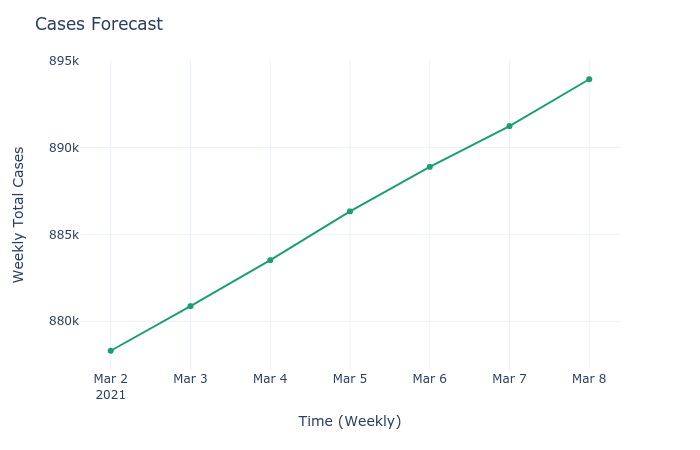

In [112]:
def view_data(d, target, date_col):
    fig = px.line(d[target], x=d.index.get_level_values(date_col), y=target[0], color_discrete_sequence=px.colors.qualitative.Dark2)
    fig.update_layout(xaxis=dict(title='Time (Weekly)'), yaxis=dict(title='Weekly Total '+ target[0]), title = target[0] +' Forecast')
    fig.update_traces(mode='markers+lines')
    fig.layout.template = 'plotly_white'
    fig.show('png')

view_data(df_forecast, target, date_col)

In [25]:
def predict():
    history = train[len(train)-lookbacks:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        lag = [history[i] for i in range(len(history)-lookbacks,len(history))]
        print(lag)
        yhat = coef[0]
        for d in range(lookbacks):
            yhat += coef[d+1] * lag[lookbacks-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    return predictions

[[794412.]
 [798394.]
 [802530.]
 [805794.]
 [809001.]
 [812804.]
 [815487.]
 [818755.]
 [821932.]
 [824611.]
 [828408.]
 [830612.]
 [832375.]
 [836594.]
 [839155.]
 [842590.]
 [845673.]
 [848330.]
 [850737.]
 [854190.]]
[array([794412.]), array([798394.]), array([802530.]), array([805794.]), array([809001.]), array([812804.]), array([815487.]), array([818755.]), array([821932.]), array([824611.]), array([828408.]), array([830612.]), array([832375.]), array([836594.]), array([839155.]), array([842590.]), array([845673.]), array([848330.]), array([850737.]), array([854190.])]
[array([794412.]), array([798394.]), array([802530.]), array([805794.]), array([809001.]), array([812804.]), array([815487.]), array([818755.]), array([821932.]), array([824611.]), array([828408.]), array([830612.]), array([832375.]), array([836594.]), array([839155.]), array([842590.]), array([845673.]), array([848330.]), array([850737.]), array([854190.])]
predicted=858056.163491, expected=857403.000000
[array([7

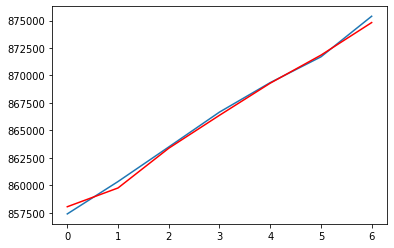

In [26]:
predictions = predict()
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(predictions)
plt.show()